# Imports 

In [ ]:
import os 
import json
from PIL import Image
import matplotlib.pyplot as plt

# Exploration du jeu de données 

## Import de la base

*Pour récupérer le Dataset, on a automatisé ça en récupérant le token de l'API Kaggle*  

*Pour récupérer le Dataset :*  
- Aller sur [Kaggle](https://www.kaggle.com/).  
- Se connecter à son compte ou s'inscrire.  
- Cliquer en haut à droite sur l'icône de son profil.  
- Aller dans la rubrique API de l'onglet settings puis "create new token".    

*Le token de l'API Kaggle est maintenant téléchargé.*  

In [ ]:
kaggle_path = os.path.expanduser("~/.kaggle")
kaggle_json_path = os.path.expanduser("~/Downloads/kaggle.json")

with open(kaggle_json_path, "r") as f:
    kaggle_token = json.load(f)

with open(os.path.join(kaggle_path, "kaggle.json"), "w") as f:
    json.dump(kaggle_token, f)

os.chmod(os.path.join(kaggle_path, "kaggle.json"), 0o600)

In [120]:
!kaggle datasets download -d mikoajkolman/pokemon-images-first-generation17000-files --unzip -p "/Users/gabriel/Desktop"

Dataset URL: https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files
License(s): GPL-2.0
100%|█████████████████████████████████████▉| 2.81G/2.81G [07:08<00:00, 7.33MB/s]
100%|██████████████████████████████████████| 2.81G/2.81G [07:08<00:00, 7.04MB/s]


*On peut regarder le nombre d'images qu'on a récupéré. Normalement on a environ 17.3K images et 143 pokémons*

In [ ]:
nombre_de_pokemon = len(os.listdir("/Users/gabriel/Desktop/pokemon"))

nombre_total_images = sum(
    len(os.listdir(os.path.join("/Users/gabriel/Desktop/pokemon", pokemon)))
    for pokemon in os.listdir("/Users/gabriel/Desktop/pokemon")
    if os.path.isdir(os.path.join("/Users/gabriel/Desktop/pokemon", pokemon)))

print(f"On a dans notre base {nombre_de_pokemon} pokémons et {nombre_total_images} images au total.")

*Le jeu de données est déjà très propre nous n'avons que très peu de clean à faire*

## Preview des images 

### Fonctions

*Avant de visualiser les images, on voit qu'elles ne sont pas toutes dans le meme format.  
On va donc standardiser tous ces formats pour avoir des images qui sont toutes au même format.*

In [140]:
def les_extensions_dossier_ss_dossier (dossier_parent):
    """ 
    Fonction qui parcourt un dossier et ses sous-dossiers pour en extraire les extensions de fichiers.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent à parcourir.

    Retourne:
    - extensions (set) : ensemble des extensions de fichiers trouvées dans le dossier et ses sous-dossiers.
    
    Exemple d'utilisation:
    extensions = les_extensions_dossier_ss_dossier("/Users/gabriel/Desktop/pokemon")
    print(extensions)
    """
    extensions = set()
    for root, sous_dossier, fichiers in os.walk(dossier_parent):
        for fichier in fichiers:
            ext = os.path.splitext(fichier)[1].lower()  
            extensions.add(ext)
    return extensions

dossier_parent = "/Users/gabriel/Desktop/pokemon"
extensions = les_extensions_dossier_ss_dossier(dossier_parent)
extensions


{'', '.bmp', '.gif', '.jpeg', '.jpg', '.png'}

In [ ]:
def convertir_en_png(dossier_parent, extensions={'.jpg', '.jpeg', '.gif', '.bmp'}):
    """ 
    Convertit toutes les images dans un dossier et ses sous-dossiers en PNG.
    Remplace les anciennes versions par la nouvelle en écrasant les fichiers.
    Renomme également les fichiers en `.png` si l'extension est mal écrite.

    Paramètres:
    - dossier_parent (str) : chemin du dossier parent à parcourir.
    - extensions (set) : ensemble des extensions de fichiers à convertir. 

    Exemple d'utilisation:
    convertir_en_png("/Users/gabriel/Desktop/pokemon")
    """

    for root, sous_dossier, fichiers in os.walk(dossier_parent):
        for fichier in fichiers:
            file_path = os.path.join(root, fichier)
            extension = os.path.splitext(fichier)[1].lower()

            if extension in extensions:
                try:
                    with Image.open(file_path) as img:
                        new_file_path = os.path.splitext(file_path)[0] + ".png"
                        img.convert("RGBA").save(new_file_path, format="PNG")
                        os.remove(file_path)
                except Exception as e:
                    print(f"Erreur avec {file_path} : {e}")

            elif extension.startswith(".png") and extension != ".png":
                new_file_path = os.path.splitext(file_path)[0] + ".png"
                os.rename(file_path, new_file_path)

dossier_parent = "/Users/gabriel/Desktop/pokemon"
convertir_en_png(dossier_parent)

*Nos images ont des noms qui ne parlent pas trop et qui ne se suivent pas ça rend plus compliqué la visualisation.  
Donc on va renommer toutes les images de manière standardisée.*

In [ ]:
def reindex_image (dossier_parent, nom_pokemon):
    """
    Fonction qui renomme une image d'un Pokemon pour que les index se suivent.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    - nom_pokemon (str) : nom du Pokémon cible.
    
    """
    chemin_dossier = os.path.join(dossier_parent, nom_pokemon)
    fichiers = os.listdir(chemin_dossier)
    fichiers_png = [f for f in fichiers if f.lower().endswith('.png')]
    
    for i, fichier in enumerate(fichiers_png):
        ancien_chemin = os.path.join(chemin_dossier, fichier)
        nouveau_nom = f"{nom_pokemon+str(i)}.png"
        nouveau_chemin = os.path.join(chemin_dossier, nouveau_nom)
        os.rename(ancien_chemin, nouveau_chemin)

In [ ]:
def rename_tout_reindex(dossier_parent):
    """
    Fonction qui renomme toutes les images de Pokémon dans un dossier pour que les index se suivent.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    
    """
    for nom_pokemon in os.listdir(dossier_parent):
        chemin_dossier = os.path.join(dossier_parent, nom_pokemon)
        if os.path.isdir(chemin_dossier):  
            reindex_image(dossier_parent, nom_pokemon)

*On prépare aussi une fonction qui altère nos images (les downscale vers une qualité donnée d'image, les passe en noir et blanc, ... ).  
L'objectif est d'obtenir des images standardisées, et éventuellement de différentes qualité.  
On pourra ainsi voir si en diminuant la qualité de nos images on arrive à garder a performance de nos modèles*

In [ ]:
def downscale_image(dossier_parent, nom_pokemon, numero_image, new_size = (64, 64), sauvegarde = False, keep_colors = True):
    """
    Fonction qui réduit la taille d'une image de Pokémon à une taille spécifiée.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    - nom_pokemon (str) : nom du Pokémon.
    - numero_image (int) : numéro de l'image du Pokémon.
    - new_size (tuple) : nouvelle taille de l'image (largeur, hauteur).
        Par défaut : (64, 64).
    - sauvegarde (bool) : si True, enregistre l'image redimensionnée, sinon garde-la dans la mémoire.
        Par défaut : False.
    - keep_colors (bool) : si True, conserve les couleurs, sinon convertit en noir et blanc. 
        Par défaut : True.
    
    Retourne :
    - Si `sauvegarde` est False, retourne l'image redimensionnée en mémoire.
    - Si `sauvegarde` est True, enregistre l'image redimensionnée dans le dossier et retourne `None`.

    Exemple d'utilisation:
    downscale_image("/Users/gabriel/Desktop/pokemon", "Mewtwo", 1, new_size = (64, 64), sauvegarde = True, keep_colors = False)
    """
    chemin_image = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon}{str(numero_image)}.png")
    img = Image.open(chemin_image)
    
    if not keep_colors:
        img = img.convert("L")  

    img_resized = img.resize(new_size)
    
    if sauvegarde:
        chemin_sauvegarde = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon}{str(numero_image)}_v2_downscale.png")
        img_resized.save(chemin_sauvegarde)
    else:
        return img_resized

*Et finalement on crée notre fonction pour visualiser notre image :*

In [ ]:
def affiche_pokemon (dossier_parent, nom_pokemon, numero_image , dowscaled = False ) : 
    """
    Fonction qui affiche une image de Pokémon à partir de son nom et de son numéro d'image.
    
    Paramètres:
    - dossier_parent (str) : chemin du dossier parent contenant les images.
    - nom_pokemon (str) : nom du Pokémon.
    - numero_image (int) : numéro de l'image du Pokémon.
    - dowscaled (bool) : si True, affiche l'image redimensionnée (en supposant qu'elle a été créée plus haut), sinon affiche l'image originale.
        Par défaut : False.
    """
    if not dowscaled:
        chemin_image = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon+str(numero_image)}.png")
    else:
        chemin_image = os.path.join(dossier_parent, nom_pokemon, f"{nom_pokemon+str(numero_image)}_v2_downscale.png")
    
    img = plt.imread(chemin_image)
    
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    
    plt.show()

In [153]:
rename_tout_reindex('/Users/gabriel/Desktop/pokemon')

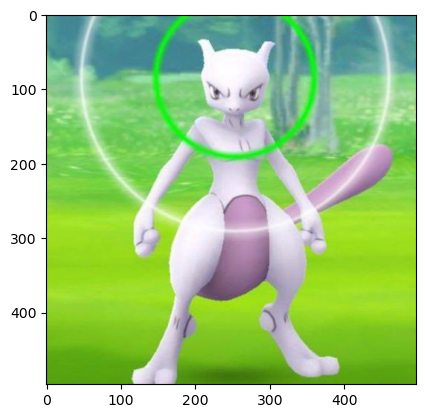

In [170]:
affiche_pokemon("/Users/gabriel/Desktop/pokemon", "Mewtwo", 0, dowscaled = False)

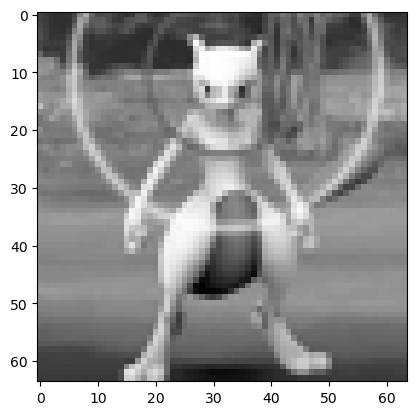

In [177]:
downscale_image("/Users/gabriel/Desktop/pokemon", "Mewtwo", 0, new_size=(64, 64), sauvegarde=True, keep_colors=False)
affiche_pokemon("/Users/gabriel/Desktop/pokemon", "Mewtwo", 0, dowscaled = True)